# Imports and Functions

In [1]:
import pandas as pd
from time import time

import visuals as vs 

%matplotlib inline

In [2]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

import seaborn as sns
sns.set()
sns.set_style("whitegrid")
flatui = ["#9b59b6","#3498db","#95a5a6","#e74c3c","#34495e","#2ecc71"]
sns.set_palette(flatui) 
sns.set(font_scale=1.5)

def conf_matrix(y_test, preds, classes, normalize_conf_mat=False, figsize=(40,40)):    
    conf_mat = confusion_matrix(preds, y_test, labels=classes)
    fig, ax = plt.subplots(figsize=figsize)
    
    # normalize by row
    if normalize_conf_mat:
        conf_mat = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis] #normalização dos valores 
        df_cm = pd.DataFrame(conf_mat, index=classes, #cria um data frame para base ao gráfico
                          columns=classes)        
        sns.heatmap(df_cm, cmap='BuPu', annot=True, 
                    xticklabels=classes, yticklabels=classes)
    else: 
        sns.heatmap(conf_mat, annot=True, fmt='d', cmap="BuPu",
                xticklabels=classes, yticklabels=classes)
        
    plt.tight_layout()
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
import scikitplot as skplt

def train(model, X_train, y_train):
    clf = Pipeline([('vect', TfidfVectorizer(min_df=3,  max_features=None, 
                    strip_accents='unicode', analyzer='word',tokenizer=word_tokenize,
                    ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1)),
                    ('clf', model)
                  ])
    
    clf.fit(X_train.tolist(), y_train)
    
    model_name = type(clf.named_steps['clf']).__name__    
    preds = clf.predict(X_train)
    acc = np.mean(preds == y_train)
    print(f'{model_name}: train accuracy {acc}')
    
    return clf, acc
    
def evaluate_(clf, X_test, y_test, verbose=False, normalize_conf_mat=False):
    model_name = type(clf.named_steps['clf']).__name__    
    y_pred = clf.predict(X_test)
    acc = np.mean(y_pred == y_test)
    print(f'{model_name}: test accuracy {acc}')
    
    y_probas = clf.predict_proba(X_test)
          
    if verbose:        
        show_roc(y_test, y_probas, model_name)    
        show_report(y_test, y_pred)
        conf_matrix(y_test, y_pred, clf.classes_, normalize_conf_mat)
        
    return acc
          
def train_evaluate(model, X_train, y_train, X_test, y_teste, verbose=False, normalize_conf_mat=False):
    clf, acc_train = train(model, X_train, y_train)
    acc_test = evaluate(clf, X_test, y_test, verbose, normalize_conf_mat)
    return clf, acc_train, acc_test
        
          
def show_roc(y_test, y_probas, name, figsize=(40,40)):
    skplt.metrics.plot_roc(y_test, y_probas,  plot_macro=False, plot_micro=False, figsize=figsize)
    plt.tight_layout()
    plt.title(name)
    plt.show()
          
def show_report(y_test, y_pred):
    #print('roc_auc_score %s' % roc_auc_score(y_test, y_pred)) 
    #print('accuracy %s' % accuracy_score(y_pred, y_test))
    print(classification_report(y_test, y_pred))

# Load Data

In [4]:
df_data = pd.read_csv('../data/data_feat.csv')
df_data.head()

,SUBJECT,AUTHOR,TEXT,TEXT_CLEAN,NUM_STOPWORDS,NUM_PUNCTUATIONS,NUM_WORDS_UPPER,NUM_CHARS,NUM_WORDS,AVG_WORD
0,ASSUNTOS VARIADOS,LUIZ FLAVIO SAPORI,19/03/2009\nFATO CORRIQUEIRO\nO fato mais impo...,19 03 2009 fato corriqueiro fato importante se...,67,29,5,1375,199,5.787129
1,ASSUNTOS VARIADOS,LUIZ FLAVIO SAPORI,06/07/2009\nPOLÍTICA DE ESTADO\nUm problema cr...,06 07 2009 politica estado problema cronico po...,75,29,11,1342,207,5.449275
2,ASSUNTOS VARIADOS,LUIZ FLAVIO SAPORI,12/07/2009\nTOQUE DE RECOLHER\nProcurado para ...,12 07 2009 toque recolher procurado suspender ...,95,46,11,1587,257,5.180392
3,ASSUNTOS VARIADOS,LUIZ FLAVIO SAPORI,23/03/2009\nCRISE SOCIOEDUCATIVA\nOcorreram du...,23 03 2009 crise socioeducativa ocorreram duas...,55,26,6,1141,167,5.761905
4,ASSUNTOS VARIADOS,LUIZ FLAVIO SAPORI,24/12/2008\nESTATÍSTICAS CRIMINAIS CONFIÁVEIS\...,24 12 2008 estatisticas criminais confiaveis b...,133,43,17,2309,366,5.246612


In [5]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3003 entries, 0 to 3002
Data columns (total 10 columns):
SUBJECT             3003 non-null object
AUTHOR              3003 non-null object
TEXT                3003 non-null object
TEXT_CLEAN          3003 non-null object
NUM_STOPWORDS       3003 non-null int64
NUM_PUNCTUATIONS    3003 non-null int64
NUM_WORDS_UPPER     3003 non-null int64
NUM_CHARS           3003 non-null int64
NUM_WORDS           3003 non-null int64
AVG_WORD            3003 non-null float64
dtypes: float64(1), int64(5), object(4)
memory usage: 234.7+ KB


# Prep Data

In [6]:
df_data['SUBJECT'] = df_data['SUBJECT'].astype('category')
df_data['AUTHOR'] = df_data['AUTHOR'].astype('category')

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_data['TEXT_CLEAN'], df_data['AUTHOR'],
                                                    test_size=0.3, stratify=df_data['AUTHOR'], random_state=42)

In [8]:
print(f'train size {len(X_train)}')
print(f'test size {len(X_test)}')

train size 2102
test size 901


# Baseline

In [9]:
# Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import f1_score, accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner.fit(X_train[:sample_size],y_train[:sample_size])
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end-start
        
    # Get the predictions on the test set(X_test),
    #       then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train)
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end-start
            
    # Compute accuracy on the training samples 
    results['acc_train'] = accuracy_score(y_train,predictions_train)
        
    # Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test,predictions_test)
    
    # Compute F-score on the training samples using fbeta_score()
    results['f1_train'] = f1_score(y_train,predictions_train,average='micro')
        
    # Compute F-score on the test set which is y_test
    results['f1_test'] = f1_score(y_test,predictions_test,average='micro')
       
    # Success
    if learner.__class__.__name__ == 'Pipeline':
        print("{} trained on {} samples.".format(type(learner.named_steps['clf']).__name__, sample_size)) 
    else:
        print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

In [12]:
# Import the three supervised learning models from sklearn
#from sklearn.neighbors import KNeighborsClassifier
#from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neural_network import MLPClassifier
#from sklearn.ensemble import RandomForestClassifier
from nltk import word_tokenize

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vec = TfidfVectorizer(min_df=3,  max_features=None, analyzer='word',tokenizer=word_tokenize,
                    ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1)

# Initialize the three models
clf_A = Pipeline([('vect', tfidf_vec),
                  ('clf', LogisticRegression(solver='lbfgs', random_state=42, n_jobs=-1))
                 ])

clf_B = Pipeline([('vect', tfidf_vec), 
                  ('clf', SGDClassifier(random_state=42, n_jobs=-1))
                 ])

clf_C = Pipeline([('vect', tfidf_vec), 
                  ('clf', MLPClassifier(learning_rate='adaptive', early_stopping=True, random_state=42))
                 ])

# Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_1 = int(len(X_train)/100)
samples_10 = int(len(X_train)/10)
samples_100 = int(len(X_train))

In [13]:
# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    if clf.__class__.__name__ == 'Pipeline':
        clf_name = type(clf.named_steps['clf']).__name__
    else:
        clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

LogisticRegression trained on 21 samples.
LogisticRegression trained on 210 samples.
LogisticRegression trained on 2102 samples.


/Users/thiagovieira/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGDClassifier trained on 21 samples.


/Users/thiagovieira/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGDClassifier trained on 210 samples.


/Users/thiagovieira/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGDClassifier trained on 2102 samples.
MLPClassifier trained on 21 samples.
MLPClassifier trained on 210 samples.
MLPClassifier trained on 2102 samples.


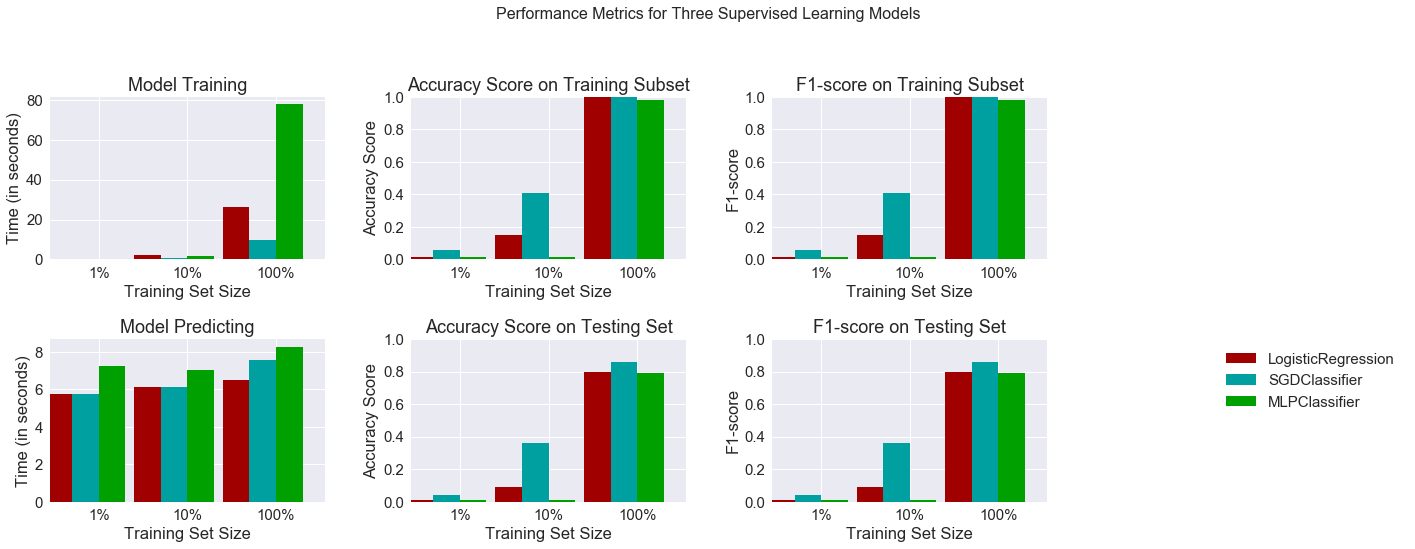

In [14]:
# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, None, None)

In [15]:
print(f"LogisticRegression: {results['LogisticRegression'][2]['f1_test']}")
print(f"SGDClassifier: {results['SGDClassifier'][2]['f1_test']}")
print(f"MLPClassifier: {results['MLPClassifier'][2]['f1_test']}")

LogisticRegression: 0.7980022197558269
SGDClassifier: 0.8568257491675916
MLPClassifier: 0.7913429522752498


In [16]:
ppl = Pipeline([('vect', tfidf_vec), 
                ('clf', SGDClassifier(loss='log', random_state=42, n_jobs=-1))
               ])
ppl.fit(X_train,y_train)

/Users/thiagovieira/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Pipeline(memory=None,
     steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=3,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=1,
     ...ty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False))])

In [17]:
preds_test = ppl.predict(X_test)
preds_train = ppl.predict(X_train)

In [18]:
print(f'Train acc: {accuracy_score(y_train,preds_train)}')        
print(f'Test acc: {accuracy_score(y_test,preds_test)}')
print(f'Train f1-score: {f1_score(y_train,preds_train,average="micro")}')
print(f'Text f1-score: {f1_score(y_test,preds_test,average="micro")}')

Train acc: 1.0
Test acc: 0.8423973362930077
Train f1-score: 1.0
Text f1-score: 0.8423973362930077


In [22]:
show_report(y_test, preds_test)

                         precision    recall  f1-score   support

    ACÍLIO LARA REZENDE       0.75      0.67      0.71         9
      ADRIANO GAMBARINI       1.00      1.00      1.00         9
      ALESSANDRA BLANCO       0.69      1.00      0.82         9
    ALEXANDRE MAGALHÃES       0.75      0.67      0.71         9
ANA CRISTINA CAVALCANTE       1.00      1.00      1.00         9
          ANDRE RIBEIRO       1.00      0.89      0.94         9
        ANDREA KAUFMANN       1.00      0.78      0.88         9
    ANTONIO PIETROBELLI       1.00      1.00      1.00         9
          ARNALDO JABOR       1.00      1.00      1.00         9
          AUGUSTO MAFUZ       1.00      1.00      1.00         9
          BADGER VICARI       1.00      0.89      0.94         9
        BENEDICTO DUTRA       0.90      1.00      0.95         9
      BOLESLAU SLIVIANY       1.00      1.00      1.00         9
           CARLA KREEFT       1.00      1.00      1.00         9
      CARLOS BERTOLAZZI 

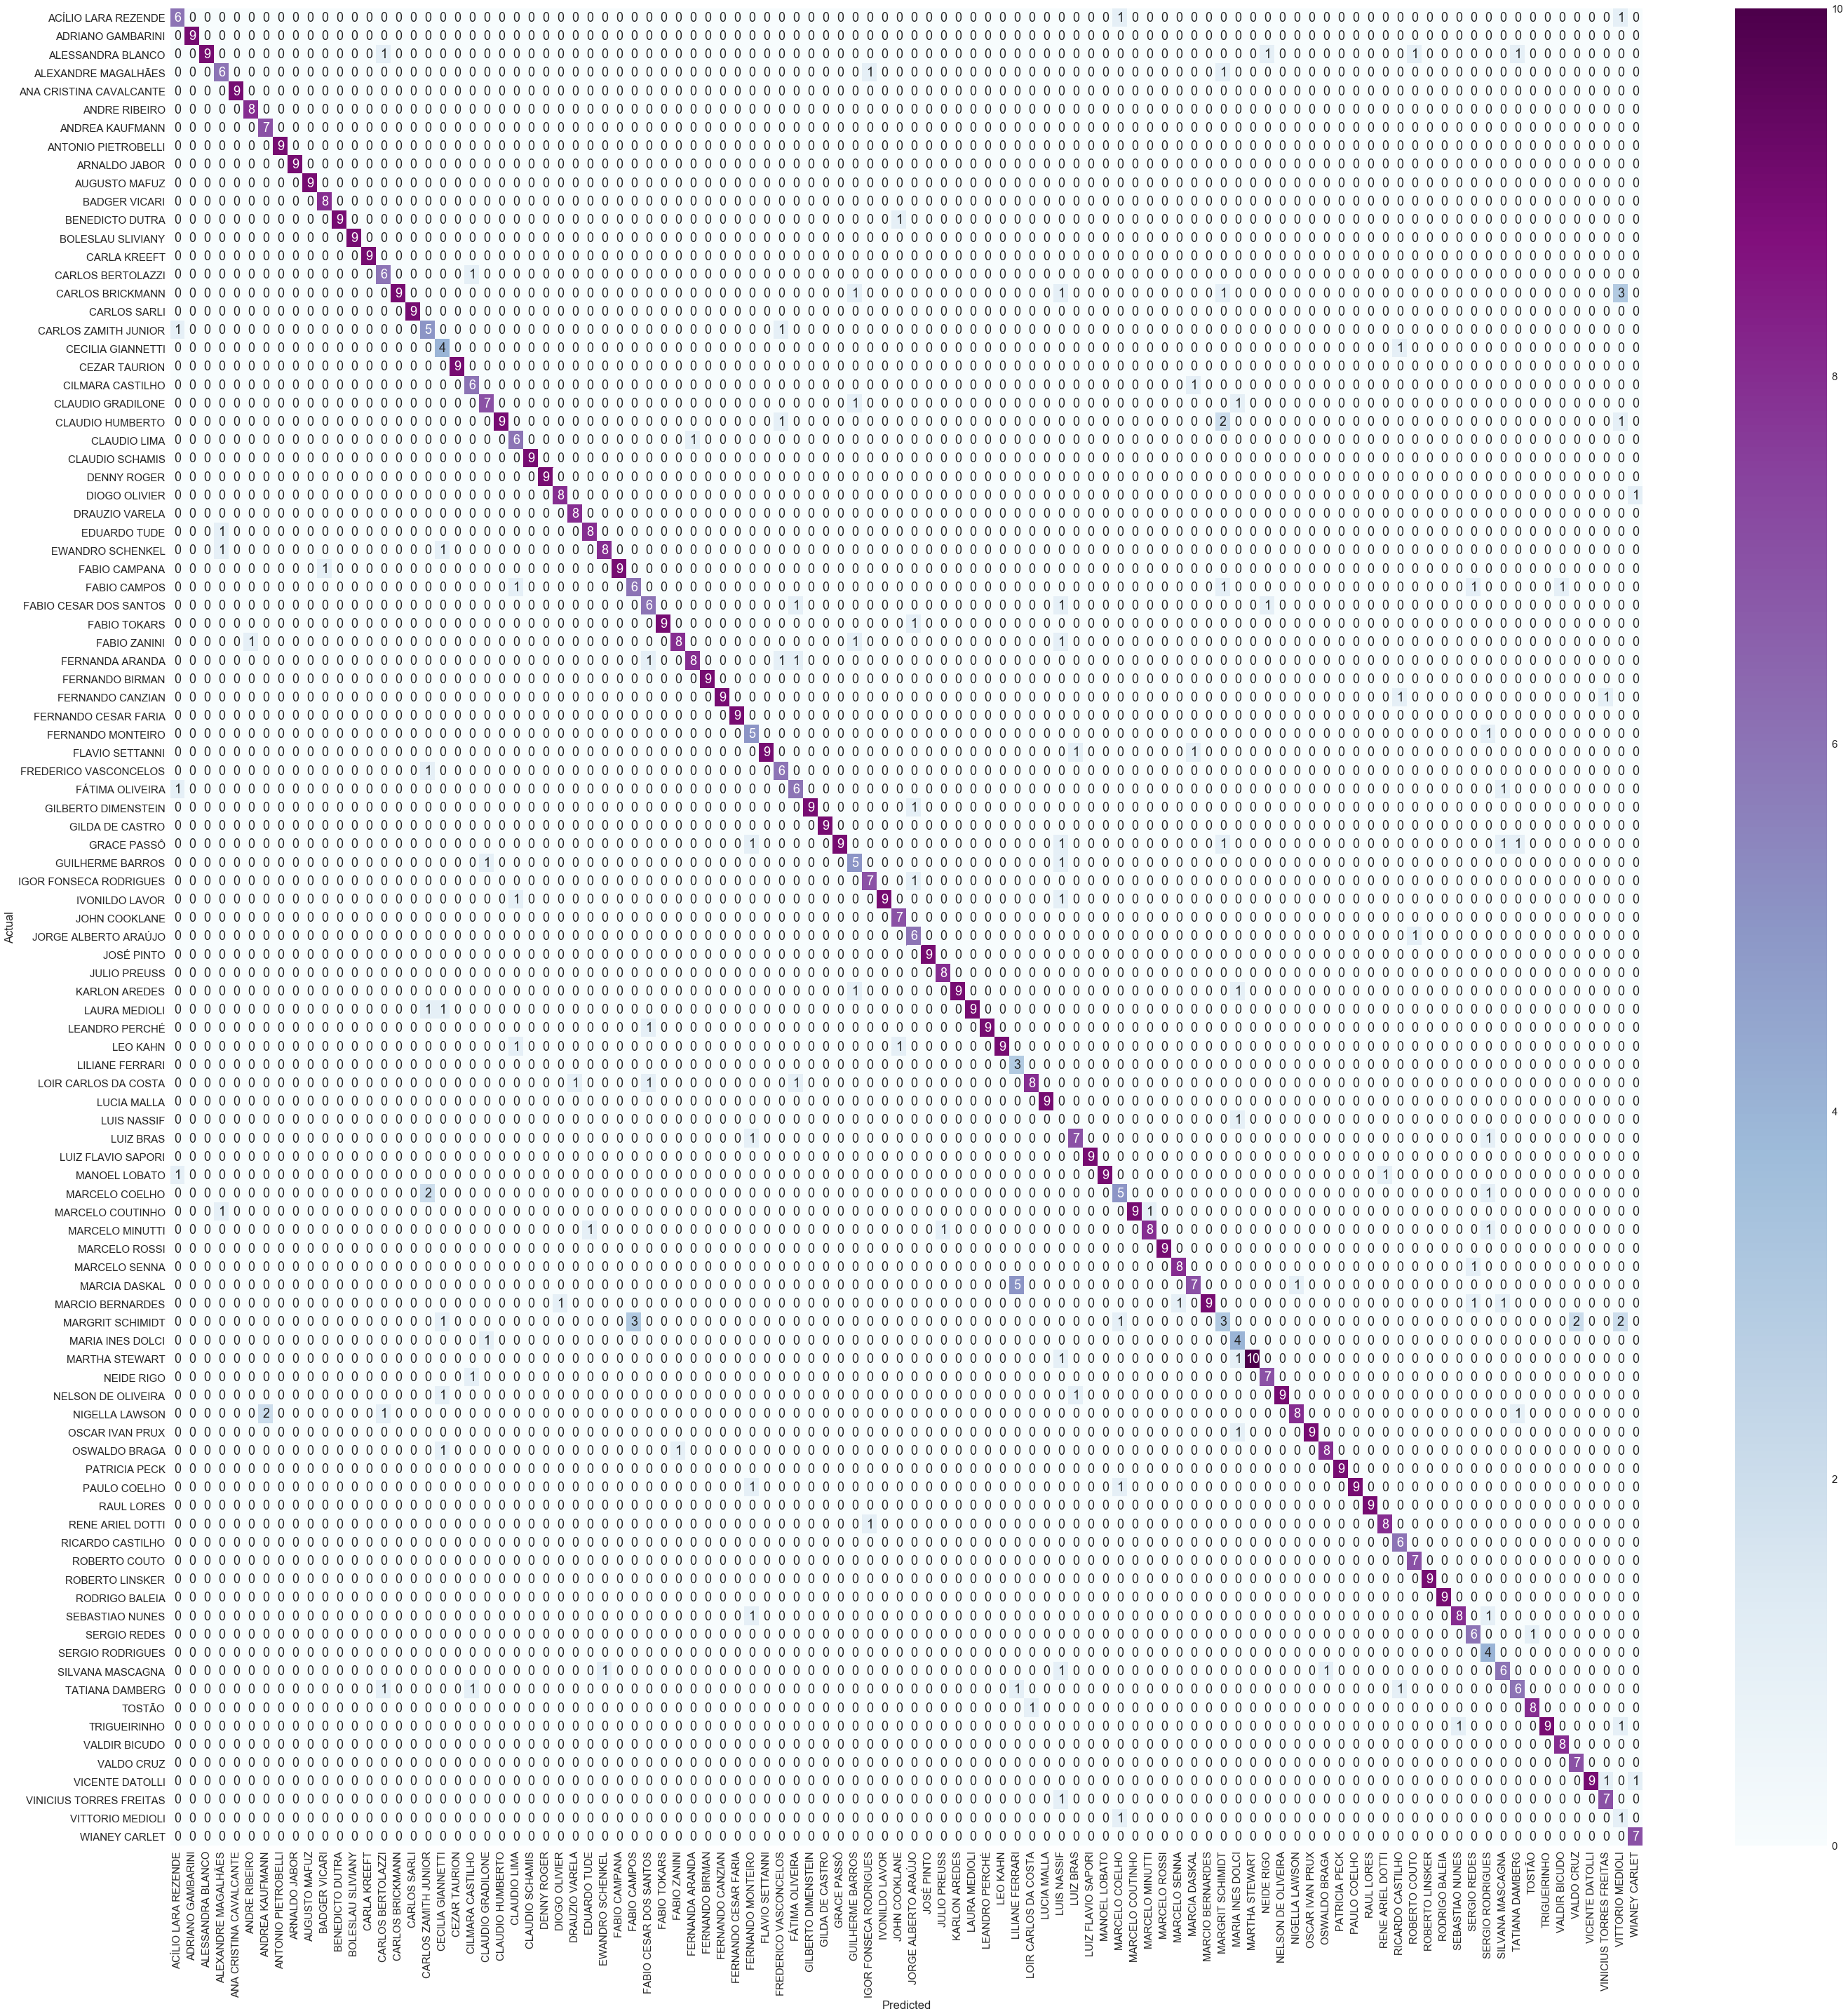

In [23]:
conf_matrix(y_test, preds_test, ppl.classes_, False)

In [25]:
y_probas = ppl.predict_proba(X_test)

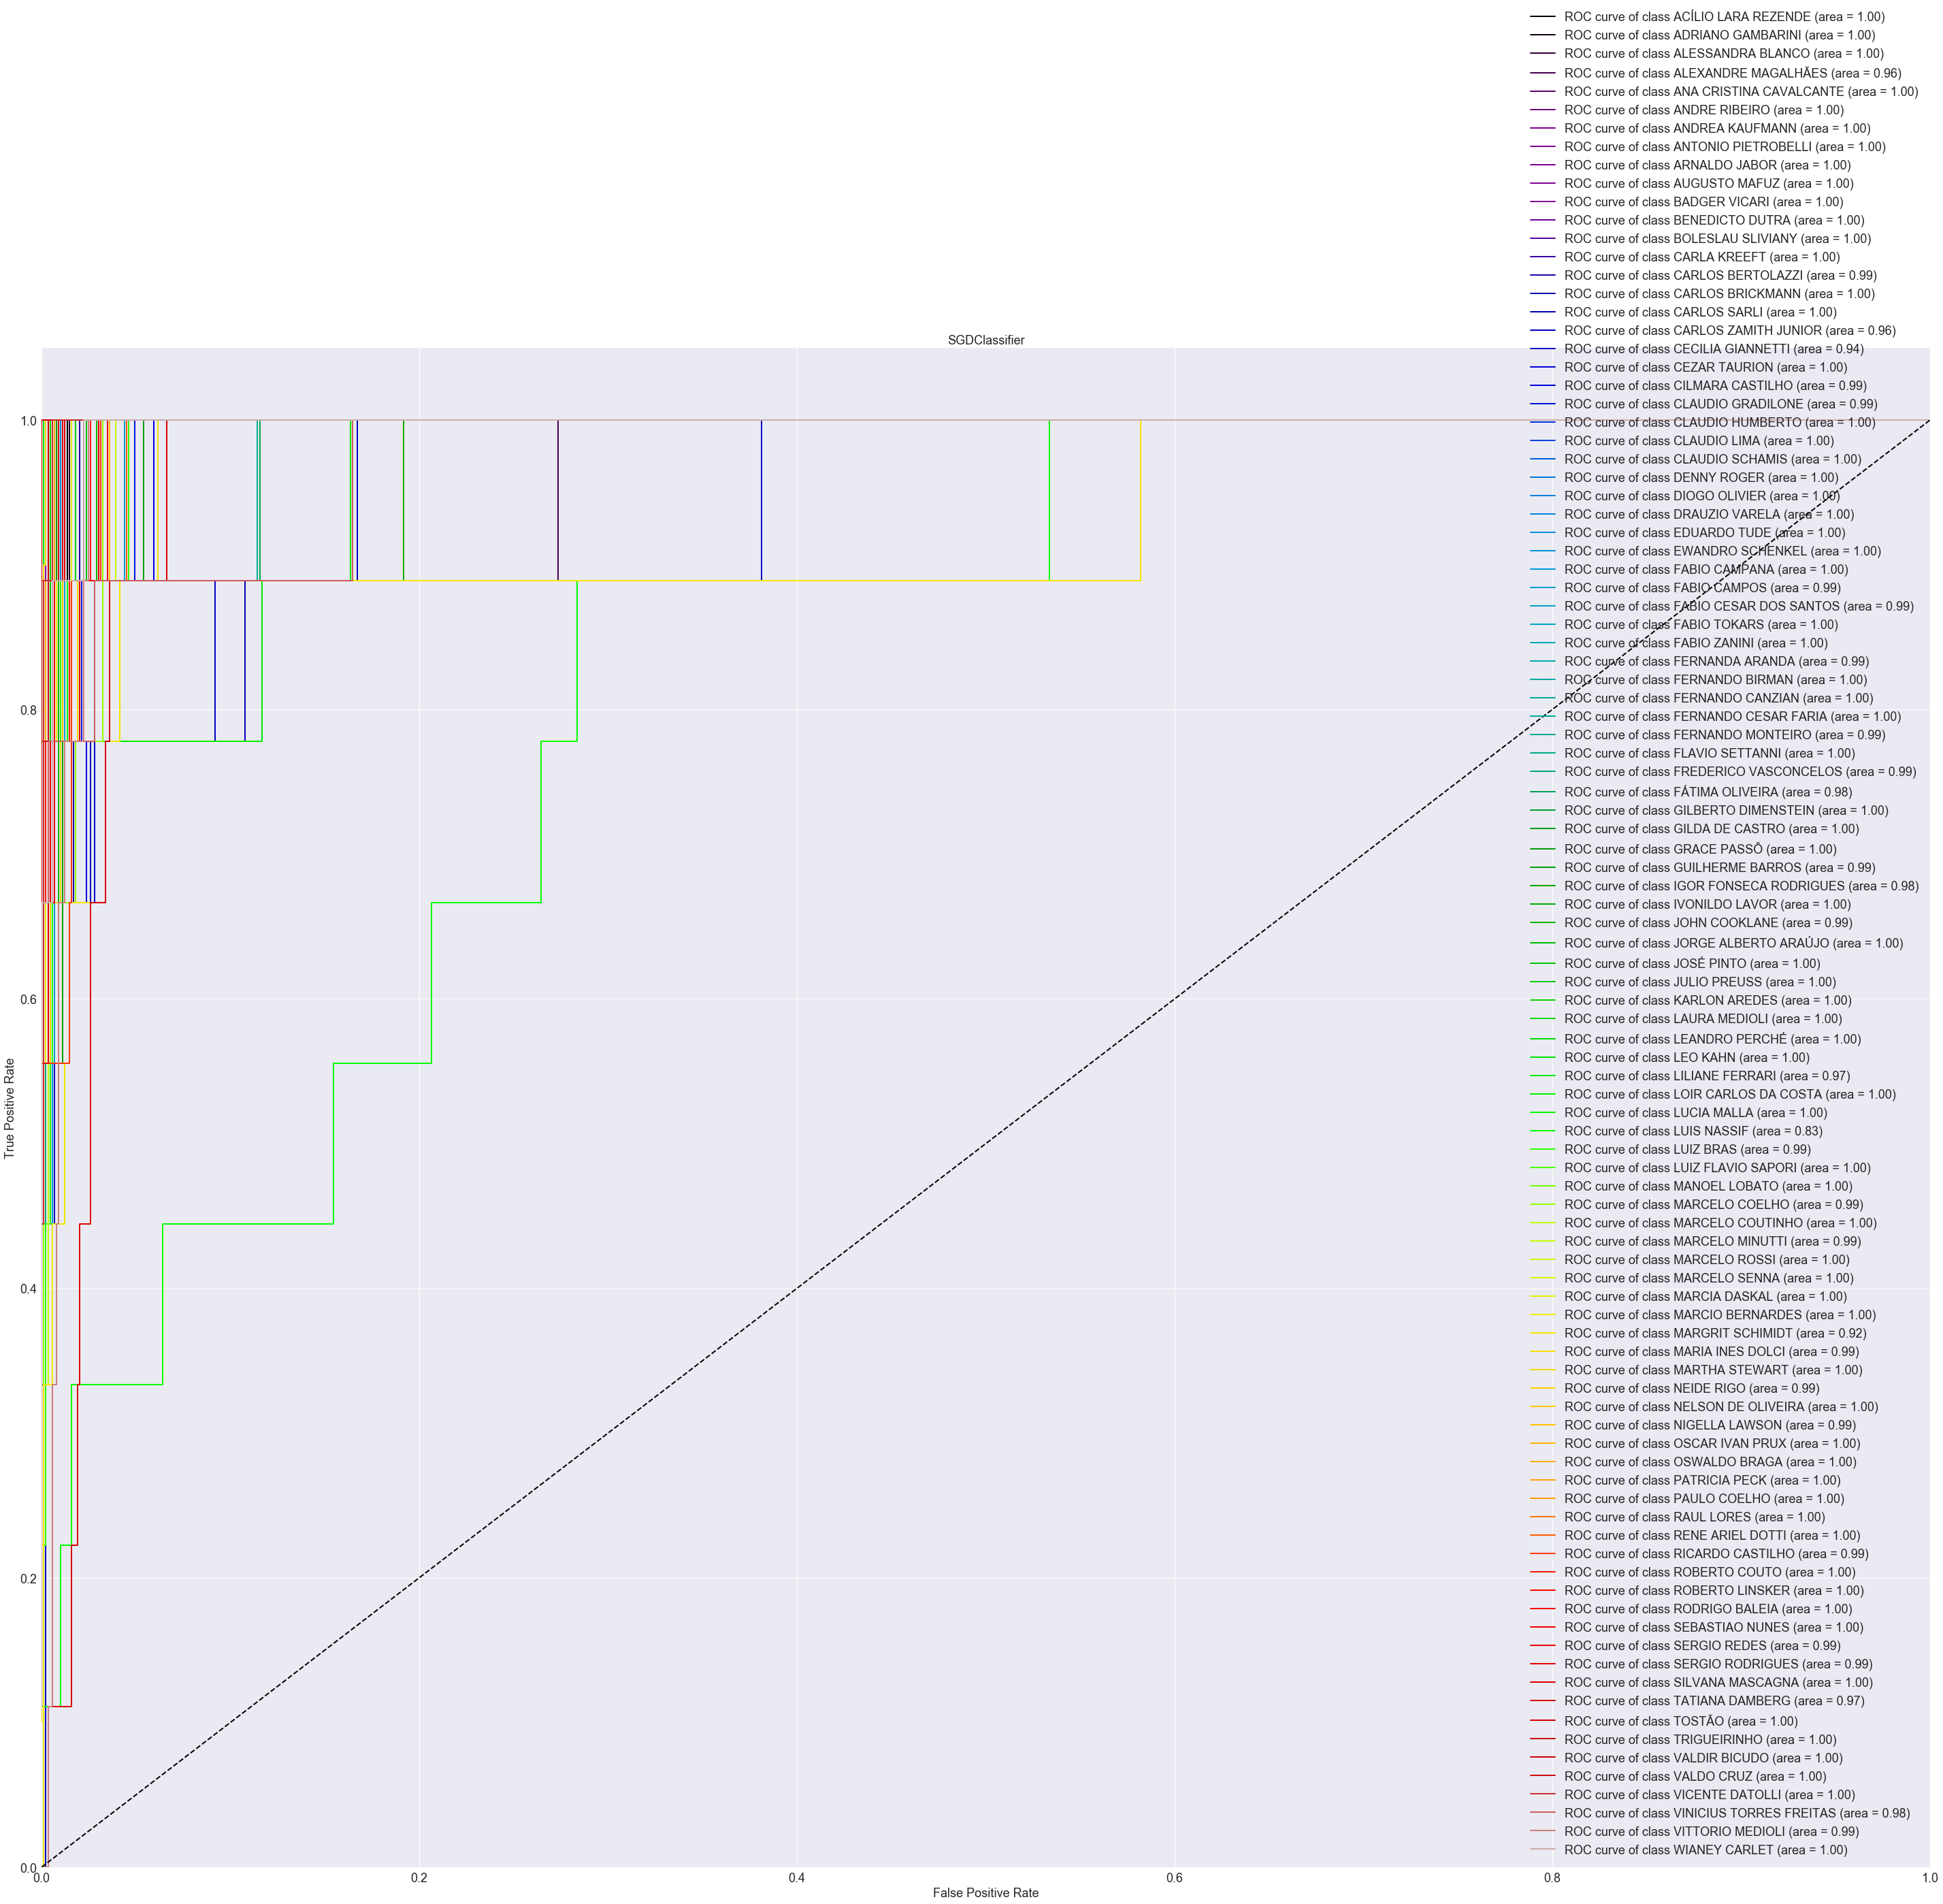

In [26]:
show_roc(y_test, y_probas, type(ppl.named_steps['clf']).__name__ )

## GridSearch

In [31]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer
from sklearn.linear_model import SGDClassifier


# Initialize the classifier
pipe = Pipeline([('vect', tfidf_vec), 
                ('clf', SGDClassifier())
               ])

# the parameters list.
parameters = {
    'clf__loss': ['log', 'hinge', 'modified_huber'],
    'clf__random_state': [42],
    'clf__n_jobs': [-1]
}

# Make an f1_score scoring object using make_scorer()
scorer = make_scorer(f1_score, average='micro')

In [32]:
# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(pipe, parameters,scoring=scorer, cv=5)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

/Users/thiagovieira/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/Users/thiagovieira/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/U

In [34]:
# Get the estimator
best_clf = grid_fit.best_estimator_

best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Optimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F1-score on the testing data: {:.4f}".format(f1_score(y_test, best_predictions, average='micro')))

Pipeline(memory=None,
     steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=3,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=1,
     ...ty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False))])
Optimized Model
------
Final accuracy score on the testing data: 0.8568
Final F1-score on the testing data: 0.8568


```
[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
          dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
          lowercase=True, max_df=1.0, max_features=None, min_df=3,
          ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=1,
          stop_words=None, strip_accents=None, sublinear_tf=1,
          token_pattern='(?u)\\b\\w\\w+\\b',
          tokenizer=<function word_tokenize at 0x1a17e4e9d8>, use_idf=1,
          vocabulary=None)),
 ('clf',
  SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
         eta0=0.0, fit_intercept=True, l1_ratio=0.15,
         learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
         n_jobs=-1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
         tol=None, verbose=0, warm_start=False))]
Optimized Model
------
Final accuracy score on the testing data: 0.8568
```

# Add average word lenght to model

In [38]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_data[['TEXT_CLEAN','AVG_WORD']], df_data['AUTHOR'],
                                                    test_size=0.3, stratify=df_data['AUTHOR'], random_state=42)

In [44]:
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline, FeatureUnion

get_text_data = FunctionTransformer(lambda x: x['TEXT_CLEAN'], validate=False)

get_numeric_data = FunctionTransformer(lambda x: x[['AVG_WORD']], validate=False)

ppl = Pipeline([
    ('features', FeatureUnion([
            ('numeric_features', Pipeline([
                ('selector', get_numeric_data),
                ('scale', StandardScaler())
            ])),
             ('word_features', Pipeline([
                ('selector', get_text_data),
                ('vect', tfidf_vec)
            ])),
         ])),
           ('clf',SGDClassifier(random_state=42, n_jobs=-1)) 
     ])

In [45]:
ppl.fit(X_train, y_train)

/Users/thiagovieira/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('numeric_features', Pipeline(memory=None,
     steps=[('selector', FunctionTransformer(accept_sparse=False,
          func=<function <lambda> at 0x1a346a90d0>, inv_kw_args=None,
          inverse_func=None, kw_args=None, pass_y='de...ty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False))])

In [46]:
preds_test = ppl.predict(X_test)
preds_train = ppl.predict(X_train)

In [47]:
print(f'Train acc: {accuracy_score(y_train,preds_train)}')        
print(f'Test acc: {accuracy_score(y_test,preds_test)}')
print(f'Train f1-score: {f1_score(y_train,preds_train,average="micro")}')
print(f'Text f1-score: {f1_score(y_test,preds_test,average="micro")}')

Train acc: 0.9895337773549001
Test acc: 0.7280799112097669
Train f1-score: 0.9895337773549001
Text f1-score: 0.7280799112097669
